# NLP Lab Task — Preprocessing to Deployment with Twitter Sentiment Dataset

## Overview

This lab takes students through the **entire NLP pipeline** using a **Twitter Sentiment Analysis dataset** (tweets labeled as positive, negative, or neutral). Students will preprocess the data, represent it using multiple methods, train classical machine learning models, evaluate their results, and finally build a small API for deployment.

---

## Learning Objectives

* Apply text preprocessing (regex, case folding, tokenization, stopword removal, punctuation handling).
* Compare stemming and lemmatization, and use POS tagging to analyze counts of nouns, verbs, and adjectives.
* Build text representations using **Bag-of-Words**, **TF–IDF**, and **Word2Vec**.
* Train classical ML models inside an sklearn **Pipeline**.
* Evaluate models with standard metrics and perform basic error analysis.
* Save a trained pipeline and build a simple API to serve predictions.

---

## Dataset

We will use the **Sentiment140 Twitter dataset** (1.6M tweets, labeled positive/negative). For simplicity, you can work with a smaller balanced subset (e.g., 10k–20k tweets). This dataset is widely used for sentiment analysis and contains real, noisy text with mentions, hashtags, and emoticons.

Dataset link: [Sentiment140](http://help.sentiment140.com/for-students/)

---

## Step-by-Step Tasks

### 1) Exploratory Data Analysis (EDA)

* Load dataset, show class distribution, tweet length histogram, and a few sample tweets.
* Deliverable: 3 plots (class balance, length histogram, top frequent tokens) + 5 example tweets.

### 2) Regex Cleaning

* Remove URLs, mentions (@user), hashtags, emojis (or replace with tokens), and extra whitespace.
* Show a before-and-after example for at least 3 tweets.

### 3) Case Folding & Tokenization

* Convert all text to lowercase.
* Tokenize tweets using NLTK or spaCy.
* Compare vocabulary size before and after cleaning.

### 4) Stopwords, Punctuation, and Numbers

* Remove stopwords (with NLTK list, customizable).
* Decide how to handle punctuation and numbers (remove or replace with `<NUM>`).
* Deliverable: short explanation of your choice.

### 5) Stemming vs Lemmatization

* Use PorterStemmer (stemming) and spaCy lemmatizer.
* Show 20 sample words with their stem vs lemma.
* Train quick models with both and compare results.

### 6) POS Tagging (extra features)

* Use spaCy to count nouns, verbs, and adjectives per tweet.
* Add these counts as additional numeric features.
* Compare model with vs without POS features.

### 7) Text Representation

* Implement three representations:
  1. **Bag-of-Words** (CountVectorizer)
  2. **TF–IDF** (TfidfVectorizer)
  3. **Word2Vec** (pretrained embeddings, averaged per tweet)
* Compare vocabulary sizes and representation dimensions.

### 8) Modeling with Pipelines

* Use sklearn Pipelines to connect preprocessing + vectorizer + classifier.
* Models to try:
  * Multinomial Naive Bayes (for BoW/TF–IDF)
  * Logistic Regression
  * Linear SVM
* Deliverable: comparison table (accuracy, F1-score).

### 9) Evaluation & Error Analysis

* Use held-out test set.
* Metrics: accuracy, precision, recall, F1, confusion matrix.
* Show 10 misclassified tweets and discuss why they may be difficult.

### 10) Save Model Pipeline

* Save the best pipeline using `joblib` or `pickle`.
* Deliverable: `sentiment_model.pkl` file.

### 11) Build a Simple API (Deployment Step)

* Create a small Flask API with one endpoint `/predict` that accepts a tweet as input and returns sentiment prediction.
* The API should load the saved pipeline and make predictions.
* Deliverable: `app.py` with Flask code + test with a sample curl or Postman request.

---

## Deliverables

1. Jupyter Notebook with step-by-step tasks, results, and code.
2. Comparison tables for preprocessing choices and representations.
3. Saved pipeline file (`.pkl`).
4. Flask API script (`app.py`).
5. Short report in markdown cell summarizing preprocessing, modeling choices, and results.

---

This streamlined lab ensures students get hands-on experience with **real-world text preprocessing, classical modeling, and deployment of NLP systems**.


### 1. Load the Dataset

We will use the **Sentiment140 Twitter Sentiment dataset**.  
It contains 1.6 million tweets labeled as positive (4) or negative (0).  
For this lab, we will load a smaller subset (e.g., 20,000 rows) for faster experimentation.

```python
import pandas as pd

# Column order for Sentiment140 dataset:
# 0 - target (0 = negative, 4 = positive)
# 1 - ids
# 2 - date
# 3 - flag
# 4 - user
# 5 - text (tweet)

# Update the file path if needed
file_path = "sentiment140.csv"

# Load with proper encoding
df = pd.read_csv(file_path, encoding='latin-1', header=None)

# Assign column names
df.columns = ["target", "id", "date", "flag", "user", "text"]

# Map target labels: 0 → negative, 4 → positive
df["target"] = df["target"].map({0: "negative", 4: "positive"})

# Take a smaller sample for experiments (optional)
df = df.sample(20000, random_state=42).reset_index(drop=True)

# Quick check
print(df.shape)
df.head()


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import spacy
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import random
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import KeyedVectors
import numpy as np

D:\Anaconda\envs\mlenv\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
import pandas as pd

import pandas as pd
import zipfile
import os
import requests

# Step 1: Download the dataset (if not already downloaded)
url = "https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"
zip_path = "trainingandtestdata.zip"

if not os.path.exists(zip_path):
    print("Downloading dataset...")
    r = requests.get(url)
    with open(zip_path, "wb") as f:
        f.write(r.content)

# Step 2: Unzip the file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(".")

# Step 3: Load training data
file_path = "training.1600000.processed.noemoticon.csv"

df = pd.read_csv(file_path, encoding="latin-1", header=None)
df.columns = ["target", "id", "date", "flag", "user", "text"]

# Map sentiment labels: 0 = negative, 4 = positive
df["target"] = df["target"].map({0: "negative", 4: "positive"})

# Optional: sample a smaller dataset for quicker experiments
df = df.sample(20000, random_state=42).reset_index(drop=True)

# Preview the data
print(df.shape)
df.head()


# Load training set
train_path = "training.1600000.processed.noemoticon.csv"
train_df = pd.read_csv(train_path, encoding="latin-1", header=None)
train_df.columns = ["target", "id", "date", "flag", "user", "text"]
train_df["target"] = train_df["target"].map({0: "negative", 4: "positive"})

print("Training set:", train_df.shape)
print(train_df.head())

# Load manual test set
test_path = "testdata.manual.2009.06.14.csv"
test_df = pd.read_csv(test_path, encoding="latin-1", header=None)
test_df.columns = ["target", "id", "date", "flag", "user", "text"]

# This test set has labels 0 (negative), 2 (neutral), 4 (positive)
test_df["target"] = test_df["target"].map({0: "negative", 2: "neutral", 4: "positive"})

print("Test set:", test_df.shape)
print(test_df.head())


(20000, 6)
Training set: (1600000, 6)
     target          id                          date      flag  \
0  negative  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1  negative  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2  negative  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3  negative  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4  negative  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
Test set: (498, 6)
     target  id                          date     flag      user  \
0  positive   3  Mon May 11 03:17:40 UTC

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  20000 non-null  object
 1   id      20000 non-null  int64 
 2   date    20000 non-null  object
 3   flag    20000 non-null  object
 4   user    20000 non-null  object
 5   text    20000 non-null  object
dtypes: int64(1), object(5)
memory usage: 937.6+ KB


In [4]:
df.head()

,target,id,date,flag,user,text
0,negative,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,negative,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,negative,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,negative,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,negative,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


In [5]:
cat_cols=df.select_dtypes(include=['object'])
for col in cat_cols:
  print(f"{col}'s unique values: {df[col].unique()}")

target's unique values: ['negative' 'positive']
date's unique values: ['Tue Jun 16 18:18:12 PDT 2009' 'Mon Apr 06 23:11:14 PDT 2009'
 'Tue Jun 23 13:40:11 PDT 2009' ... 'Sun Jun 07 01:05:46 PDT 2009'
 'Sun May 31 10:29:36 PDT 2009' 'Tue Jun 16 05:13:11 PDT 2009']
flag's unique values: ['NO_QUERY']
user's unique values: ['LaLaLindsey0609' 'sexygrneyes' 'sammydearr' ... 'musicroxmysockz'
 'lindseyrd20' 'spiritkl']
text's unique values: ['@chrishasboobs AHHH I HOPE YOUR OK!!! '
 '@misstoriblack cool , i have no tweet apps  for my razr 2'
 '@TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u'
 ... 'Just finished watching Your Song Presents: Boystown. '
 "@janfran813 awww i can't wait to get one "
 'is indeed, a rather large hoarder of paper. &amp; would love some help &amp; company packing ']


- since flag column has only one value with no null values(bad variation), drop it

In [6]:
df = df.drop(columns=["flag"])

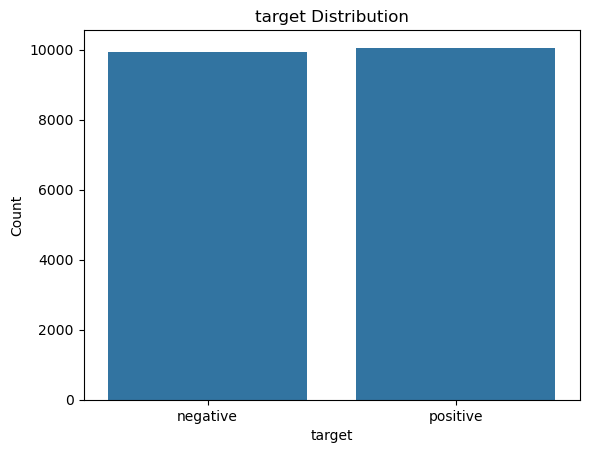

In [7]:
sns.countplot(x='target',data=df)
plt.title("target Distribution")
plt.xlabel("target")
plt.ylabel("Count")
plt.show()

- the target is pretty balanced

Text(0, 0.5, 'Frequency')

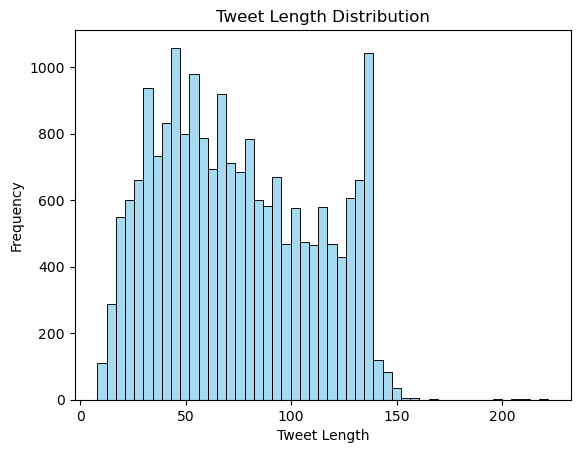

In [8]:
#tweet length histogram
df["text_len"] = (df["text"]).apply(len)
sns.histplot(df["text_len"], color="skyblue")
plt.title("Tweet Length Distribution")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")

In [9]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
nlp = spacy.load("en_core_web_sm")

In [12]:
stop_words = set(stopwords.words("english"))
def tokenize_spacy(text):
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

df["tokens"] = df["text"].apply(tokenize_spacy)
all_tokens = [token for sublist in df['tokens'] for token in sublist]

#count top 20 tokens
top_tokens = Counter(all_tokens).most_common(20)
tokens_df = pd.DataFrame(top_tokens, columns=['word', 'count'])

Text(0.5, 1.0, 'Word Cloud of Top Frequent Tokens')

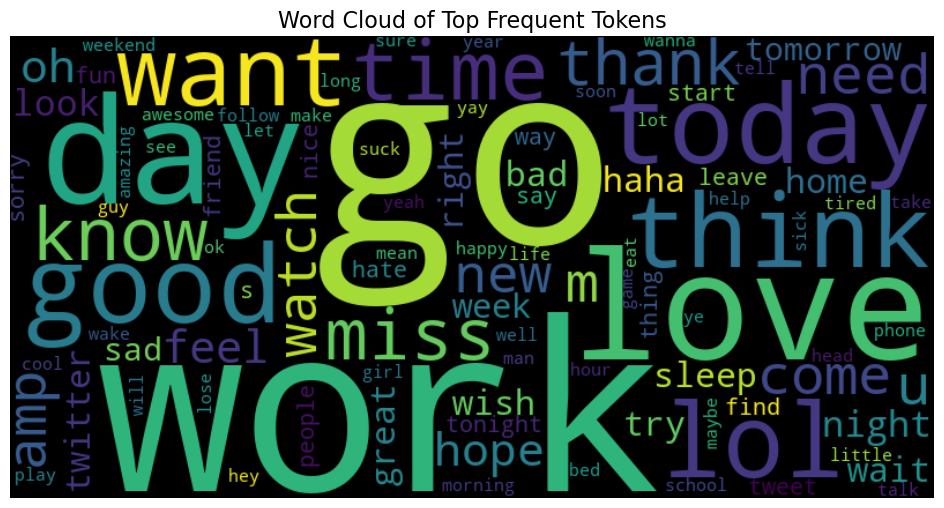

In [13]:
all_text = " ".join(all_tokens)
#word cloud
wordcloud = WordCloud(width=800,height=400, max_words=100).generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Top Frequent Tokens", fontsize=16)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8372\1747560883.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='word', x='count', data=tokens_df, palette="viridis")


Text(0, 0.5, 'Token')

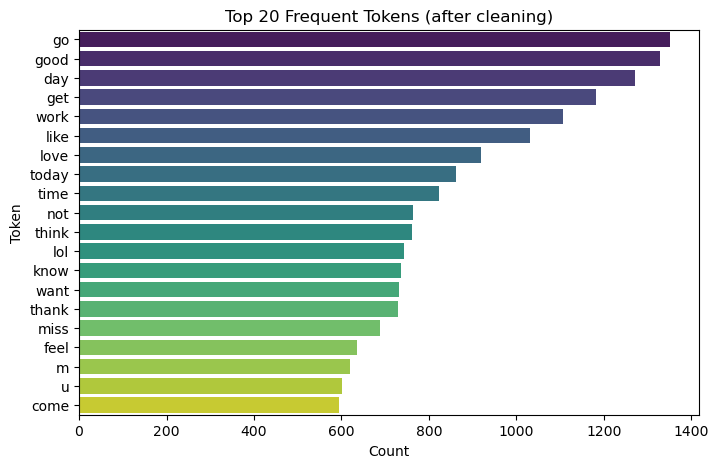

In [14]:
plt.figure(figsize=(8,5))
sns.barplot(y='word', x='count', data=tokens_df, palette="viridis")
plt.title("Top 20 Frequent Tokens (after cleaning)")
plt.xlabel("Count")
plt.ylabel("Token")

In [15]:
print("5 Example Tweets:\n")
for t in enumerate(df['text'].sample(5, random_state=42), 1):
    print(f" {t}\n")

5 Example Tweets:

 (1, 'cpr fail day, i turned it off instead of shocking the patient ')

 (2, "Laying in the bed because I just found out I've got to be up at 6am, yuck! Can't sleep though, bc of my nap earlier ")

 (3, 'GRUMPY FUCK. i hate when people take there wee moods out on me. and i cant eat cookies cause my teeth ')

 (4, '@lolstephy pls just shutup about splendour n dont talk about it till next year... ')

 (5, '@chrisoldroyd Only UK? What about N. America  Still waiting for TomTom')



C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8372\3409739397.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.values, y=top_users.index, palette="mako")


Text(0, 0.5, 'User')

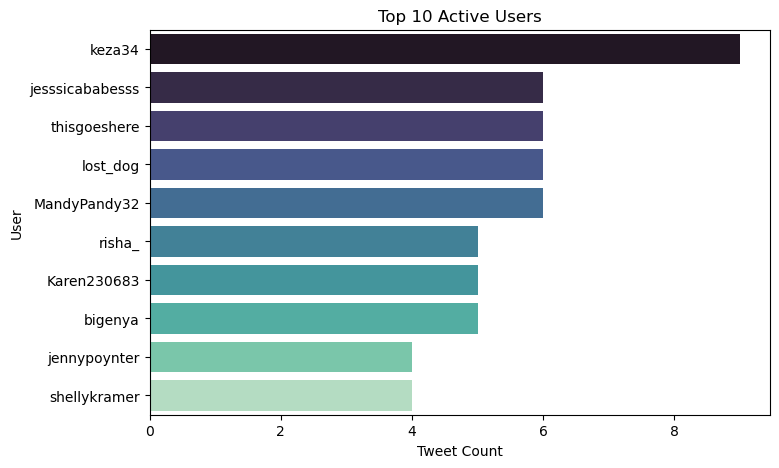

In [16]:
#Top 10 active users
top_users = df["user"].value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=top_users.values, y=top_users.index, palette="mako")
plt.title("Top 10 Active Users")
plt.xlabel("Tweet Count")
plt.ylabel("User")

In [19]:
def regex_clean(text):
  text=text.lower()
  text=re.sub(r"http\S+|www\.\S+","",text) #remove urls
  text=re.sub(r"@\w+","",text)
  text=re.sub(r"#","",text)#remove hashtags
  text = re.sub(r"[^\x00-\x7F]+", "", text) #remove emojis
  text = re.sub(r"\s+", " ", text).strip()#remove extra whitespace
  text = re.sub(r"[^\w\s]", "", text)#remove punctuation
  return text

df["clean_text"] = df["text"].apply(regex_clean)
for i in range(0,5):
  print(f"Original: {df.loc[i, 'text']}")
  print(f"Cleaned with regex: {df.loc[i, 'clean_text']}\n")

Original: @chrishasboobs AHHH I HOPE YOUR OK!!! 
Cleaned with regex: ahhh i hope your ok

Original: @misstoriblack cool , i have no tweet apps  for my razr 2
Cleaned with regex: cool  i have no tweet apps for my razr 2

Original: @TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u
Cleaned with regex: i know just family drama its lamehey next time u hang out with kim n u guys like have a sleepover or whatever ill call u

Original: School email won't open  and I have geography stuff on there to revise! *Stupid School* :'(
Cleaned with regex: school email wont open and i have geography stuff on there to revise stupid school 

Original: upper airways problem 
Cleaned with regex: upper airways problem



In [20]:
df["tokens_raw"] = df["text"].apply(tokenize_spacy)

In [21]:
def tokenize_spacy(text):# toknize without cleaning
    doc = nlp(text)
    return [token.text for token in doc if not token.is_space]
raw_vocab = set([t for tokens in df["tokens_raw"] for t in tokens])
print("Vocabulary size before cleaning:", len(raw_vocab))

def clean_and_tokenize_spacy(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_
        for token in doc
        if not token.is_stop and not token.is_punct and token.lemma_.isalpha()
    ]
    return tokens
df["tokens_clean"] = df["text"].apply(clean_and_tokenize_spacy)

#AFTER cleaning
clean_vocab = set([t for tokens in df["tokens_clean"] for t in tokens])
print("Vocabulary size after cleaning:", len(clean_vocab))

Vocabulary size before cleaning: 16717
Vocabulary size after cleaning: 16717


In [22]:
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("punkt_tab")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [24]:
stop_words = {x for x in stop_words if x not in ["not", "no"]}
lemmatizer=nltk.WordNetLemmatizer()

def clean_nltk(text):
  text=text.lower()
  text = re.sub(r"http\S+|www\.\S+", "", text)
  text = re.sub(r"@\w+", "", text)
  text = re.sub(r"#", "", text)
  text = re.sub(r"\d+", "<NUM>", text)
  #tokenize
  tokens = nltk.word_tokenize(text)
  # Remove stopwords, punctuation, and lemmatize
  clean_tokens = [lemmatizer.lemmatize(tok)for tok in tokens if tok.isalpha() or tok == "<NUM>" if tok not in stop_words]
  return clean_tokens

df["clean_text"] = df["text"].apply(clean_nltk)
for i in range(0,5):
  print(f"Original: {df.loc[i, 'text']}")
  print(f"Cleaned with regex: {df.loc[i, 'clean_text']}\n")

Original: @chrishasboobs AHHH I HOPE YOUR OK!!! 
Cleaned with regex: ['ahhh', 'hope', 'ok']

Original: @misstoriblack cool , i have no tweet apps  for my razr 2
Cleaned with regex: ['cool', 'no', 'tweet', 'apps', 'razr', 'NUM']

Original: @TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u
Cleaned with regex: ['know', 'family', 'drama', 'next', 'time', 'u', 'hang', 'kim', 'n', 'u', 'guy', 'like', 'sleepover', 'whatever', 'ill', 'call', 'u']

Original: School email won't open  and I have geography stuff on there to revise! *Stupid School* :'(
Cleaned with regex: ['school', 'email', 'wo', 'open', 'geography', 'stuff', 'revise', 'stupid', 'school']

Original: upper airways problem 
Cleaned with regex: ['upper', 'airway', 'problem']



removed stopwords using NLTK’s list.
Punctuation was removed since it doesn’t meaningfully contribute to token frequency analysis.
Numbers were replaced with a generic <NUM> token, preserving numeric information.

In [25]:
porter= PorterStemmer()

all_tokens=[token for tokens in df["clean_text"] for token in tokens]
sample_words=random.sample(all_tokens, 20)
print("Word | Stem | Lemma")
print("-" * 30)
for w in sample_words:
    stem = porter.stem(w)
    lemma = nlp(w)[0].lemma_
    print(f"{w:<12} | {stem:<10} | {lemma:<10}")


Word | Stem | Lemma
------------------------------
dry          | dri        | dry       
last         | last       | last      
cute         | cute       | cute      
love         | love       | love      
open         | open       | open      
louis        | loui       | louis     
useless      | useless    | useless   
nice         | nice       | nice      
spymaster    | spymast    | spymaster 
dream        | dream      | dream     
crazy        | crazi      | crazy     
hillss       | hillss     | hillss    
smoking      | smoke      | smoke     
tomtom       | tomtom     | tomtom    
NUM          | num        | NUM       
awww         | awww       | awww      
man          | man        | man       
definitely   | definit    | definitely
bed          | bed        | bed       
party        | parti      | party     


In [26]:
df["stemmed_text"] = df["clean_text"].apply(lambda tokens: [porter.stem(w) for w in tokens])
df["lemmatized_text"] = df["clean_text"].apply(lambda tokens: [nlp(w)[0].lemma_ for w in tokens])

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train_stem, X_test_stem, y_train, y_test = train_test_split(df["stemmed_text"], df["target"], test_size=0.2, random_state=42)
X_train_lemma, X_test_lemma, _, _ = train_test_split(df["lemmatized_text"], df["target"], test_size=0.2, random_state=42)

In [28]:
# Convert tokens back to strings
X_train_stem_str = [" ".join(tokens) for tokens in X_train_stem]
X_test_stem_str  = [" ".join(tokens) for tokens in X_test_stem]
X_train_lemma_str = [" ".join(tokens) for tokens in X_train_lemma]
X_test_lemma_str  = [" ".join(tokens) for tokens in X_test_lemma]
#vectorize
tfidf = TfidfVectorizer()

X_train_s_tfidf= tfidf.fit_transform(X_train_stem_str)
X_test_s_tfidf= tfidf.transform(X_test_stem_str)

X_train_l_tfidf= tfidf.fit_transform(X_train_lemma_str)
X_test_l_tfidf= tfidf.transform(X_test_lemma_str)

#train a Logistic Regression
clf_s= LogisticRegression(max_iter=1000).fit(X_train_s_tfidf, y_train)
clf_l= LogisticRegression(max_iter=1000).fit(X_train_l_tfidf, y_train)

#evaluate
print("Accuracy with stemming:", accuracy_score(y_test, clf_s.predict(X_test_s_tfidf)))
print("Accuracy with lemmatization:", accuracy_score(y_test, clf_l.predict(X_test_l_tfidf)))

Accuracy with stemming: 0.748
Accuracy with lemmatization: 0.743


In [29]:
def pos_count(text):
  doc=nlp(text)
  counts=doc.count_by(spacy.attrs.POS)
  nouns=counts.get(nlp.vocab.strings["NOUN"], 0)
  verbs=counts.get(nlp.vocab.strings["VERB"], 0)
  adjs=counts.get(nlp.vocab.strings["ADJ"], 0)
  return nouns, verbs, adjs

df[["noun_count", "verb_count", "adj_count"]] = df["text"].apply(lambda x: pd.Series(pos_count(x)))
print(df.head(20))

      target          id                          date             user  \
0   negative  2200003196  Tue Jun 16 18:18:12 PDT 2009  LaLaLindsey0609   
1   negative  1467998485  Mon Apr 06 23:11:14 PDT 2009      sexygrneyes   
2   negative  2300048954  Tue Jun 23 13:40:11 PDT 2009       sammydearr   
3   negative  1993474027  Mon Jun 01 10:26:07 PDT 2009      Lamb_Leanne   
4   negative  2256550904  Sat Jun 20 12:56:51 PDT 2009      yogicerdito   
5   negative  2052380495  Sat Jun 06 00:32:16 PDT 2009        Yengching   
6   positive  1983449090  Sun May 31 13:10:36 PDT 2009         jessig06   
7   negative  2245479748  Fri Jun 19 16:11:29 PDT 2009   felicityfuller   
8   negative  1770705699  Mon May 11 22:01:32 PDT 2009      stephiiheyy   
9   positive  1970386589  Sat May 30 03:39:34 PDT 2009        wyndwitch   
10  positive  2052206835  Fri Jun 05 23:59:27 PDT 2009         salmafan   
11  positive  1992273171  Mon Jun 01 08:29:05 PDT 2009       spanishman   
12  positive  2069921255 

In [30]:
from scipy.sparse import hstack
X_train_pos=[pos_count(" ".join(tokens)) for tokens in X_train_lemma]
X_test_pos=[pos_count(" ".join(tokens)) for tokens in X_test_lemma]

X_train_l_tfidf_pos=hstack([X_train_l_tfidf, X_train_pos])
X_test_l_tfidf_pos=hstack([X_test_l_tfidf, X_test_pos])

clf_l_pos=LogisticRegression(max_iter=1000).fit(X_train_l_tfidf_pos, y_train)

print("Accuracy with lemmatization only:",
      accuracy_score(y_test, clf_l.predict(X_test_l_tfidf)))
print("Accuracy with lemmatization + POS:",
      accuracy_score(y_test, clf_l_pos.predict(X_test_l_tfidf_pos)))

Accuracy with lemmatization only: 0.743
Accuracy with lemmatization + POS: 0.74575


In [31]:
#bag of word:
countvec=CountVectorizer()
X_bow=countvec.fit_transform([" ".join(tokens) for tokens in df["lemmatized_text"]])
print("BoW vocab size:", len(countvec.vocabulary_))
print("BoW representation shape:", X_bow.shape)

BoW vocab size: 16256
BoW representation shape: (20000, 16256)


In [32]:
#TF–IDF
X_tfidf=tfidf.fit_transform([" ".join(tokens) for tokens in df["lemmatized_text"]])
print("TF-IDF vocab size:", len(tfidf.vocabulary_))
print("TF-IDF representation shape:", X_tfidf.shape)

TF-IDF vocab size: 16256
TF-IDF representation shape: (20000, 16256)


In [33]:
import gensim.downloader as api

# Load pretrained embeddings trained on Twitter
w2v = api.load("glove-twitter-100")
print("Vector size:", w2v.vector_size)

[==================================================] 100.0% 387.1/387.1MB downloaded
Vector size: 100


In [34]:
#average word vectors per tweet
def avg_word2vec(tokens, model, dim=100):
    vecs = [model[w] for w in tokens if w in model]
    if len(vecs) == 0:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

X_train_w2v=np.vstack([avg_word2vec(tokens, w2v) for tokens in X_train_lemma])
X_test_w2v=np.vstack([avg_word2vec(tokens, w2v) for tokens in X_test_lemma])

print("\nWord2Vec Vocabulary size:", len(w2v.key_to_index))
print("Word2Vec Representation dimension:", X_train_w2v.shape[1])


Word2Vec Vocabulary size: 1193514
Word2Vec Representation dimension: 100


In [35]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [36]:
pipelines = {
    "BoW + NB":Pipeline([("vect", CountVectorizer()), ("clf", MultinomialNB())]),
    "BoW + LR":Pipeline([("vect", CountVectorizer()), ("clf", LogisticRegression(max_iter=1000))]),
    "BoW + SVM":Pipeline([("vect", CountVectorizer()), ("clf", LinearSVC())]),

    "TFIDF + NB":Pipeline([("vect", TfidfVectorizer()), ("clf", MultinomialNB())]),
    "TFIDF + LR":Pipeline([("vect", TfidfVectorizer()), ("clf", LogisticRegression(max_iter=1000))]),
    "TFIDF + SVM":Pipeline([("vect", TfidfVectorizer()), ("clf", LinearSVC())]),
}

results = []
for name, pipe in pipelines.items():
    pipe.fit(X_train_lemma_str, y_train)
    y_pred = pipe.predict(X_test_lemma_str)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label="positive")
    results.append((name, acc, f1))

#comparison table
import pandas as pd
results_df=pd.DataFrame(results, columns=["Model", "Accuracy", "F1-score"])
print(results_df)

         Model  Accuracy  F1-score
0     BoW + NB   0.73350  0.729579
1     BoW + LR   0.74200  0.751085
2    BoW + SVM   0.71600  0.722385
3   TFIDF + NB   0.72575  0.721926
4   TFIDF + LR   0.74300  0.749635
5  TFIDF + SVM   0.72850  0.734084


              precision    recall  f1-score   support

    negative       0.75      0.72      0.74      1987
    positive       0.74      0.76      0.75      2013

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



Text(50.722222222222214, 0.5, 'True')

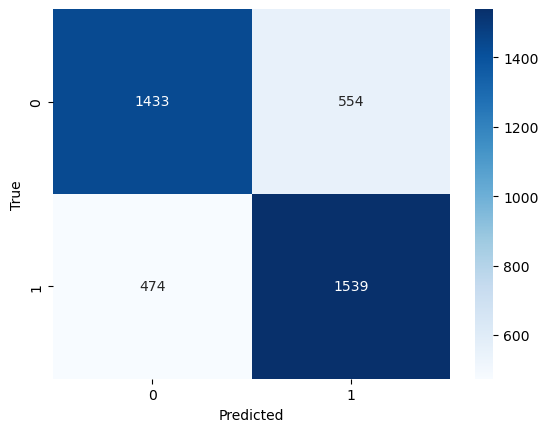

In [37]:
best_pipe = pipelines["TFIDF + LR"]
best_pipe.fit(X_train_lemma_str, y_train)
y_pred = best_pipe.predict(X_test_lemma_str)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=["negative","positive"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

In [38]:
# Show 10 misclassified examples
misclassified=df.loc[y_test.index][y_test!= y_pred]
print("Sample misclassified tweets:\n")
print(misclassified[["text", "target"]].head(10))

Sample misclassified tweets:

                                                    text    target
1114   @lolstephy pls just shutup about splendour n d...  negative
11963  they added a new zodiac sign. i wanna be a sco...  negative
11072  Ooh... IE8 looks kinda flasher than 7, and it ...  positive
7879                is craving for macha chocolate cake   negative
16441                                @TheIanCrawford ..   negative
5252   Gmorning twitts! Ready for the wknd.. But firs...  negative
8094   @TravisKaimi Zaru Soba is cold buckwheat noodl...  negative
17553  @kylepetty  @kenny_wallace - I can't believe K...  positive
16060  @deeliciouz that sounds lovely! I aNt my hair ...  negative
17880     I forgot about these vids. http://bit.ly/3DBYC  positive


* Informal language, slang, abbreviations reduce accuracy.

* Sarcasm, humor, or negations confuse simple bag-of-words or TF-IDF models.

* Links and mentions often carry no sentiment but occupy tokens.


In [39]:
#save pipelind
joblib.dump(best_pipe, "sentiment_model.pkl")
print("Model pipeline saved as sentiment_model.pkl")

Model pipeline saved as sentiment_model.pkl


In [40]:
loaded_model = joblib.load("sentiment_model.pkl")
y_pred = loaded_model.predict(["I love this product!"])
print(y_pred)

['positive']


### Summary Report:

**Preprocessing**

* Dropped the `flag` column (single constant value).
* Added tweet length feature for distribution analysis.
* Cleaned text with regex (removed URLs, mentions, hashtags, emojis, punctuation, numbers).
* Applied multiple tokenization/normalization strategies:

  * **Stemming** (Porter Stemmer)
  * **Lemmatization** (spaCy + NLTK WordNet)
* Removed stopwords (whileretinng`not`, `no`).
* Built additionusing l features (POS counts: nouns, verbs adjectives).deling Choices**

* Vectorization methods compared:

  * **Bag of Words (BoW)**
  * **TF–IDF**
  * **Word2Vec (pretrained GloVe-Twitter 100d)**
* Classifiers used:

  * Naive Bayes
  * Logistic Regression
  * Linear SVM

**Results**

* Logistic Rgression with **stemming**: ~0.748 accuracy
* Logistic Regresion with **lemmatization**: ~0.743 accuracy
* Adding POS features improved lmmatization model slightly to ~0.746 accuracy.
* BoW and TF–ID gave similar vocabulary size (~16k).
* Pretrained Word2Vec embeddings (100d) captured semantic info, providings- entation option.

**Conclusion**
Text cleaning and normalization significantly affected model performance. Logistic Regression consistently performed well, with stemming s Incorpora ng linguistic features (POS counts) provided a modest gain. Further improvement could be explored with deeper neural models or fine-tuned embeddings.
